In [1]:
import json
import pathlib
import gzip
from concurrent.futures import ProcessPoolExecutor, as_completed

from tqdm import tqdm
import torch
import numpy as np
import matplotlib.pyplot as plt

import decoder

# Parameter Changes

In [132]:
# logfile = "logs/networks/regular/nodes-8-degree-2-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-4-seed-0-heterogenous-init-2-epochs-simple-balanced_iid-100-items-gain.jsonl"
# logfile = "logs/networks/regular/nodes-32-degree-16-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-256-degree-128-seed-1-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
# logfile = "logs/networks/regular/nodes-16-degree-8-seed-0-heterogenous-init-4-epochs-simple-balanced_iid-100-items.jsonl"
logfile = "logs/regular/nodes-512-degree-32-seed-0-heterogeneous-init-1-epochs-simple-balanced_iid-100-items.jsonl.gz"

rounds = []
with gzip.open(logfile, 'rt') as f:
    for line in tqdm(f):
        rounds.append(json.loads(line, cls=decoder.TorchTensorDecoder))
# rounds = rounds[:128]
print(len(rounds))

32it [00:22,  1.41it/s]

32


Text(0, 0.5, 'STD[params] in each node')

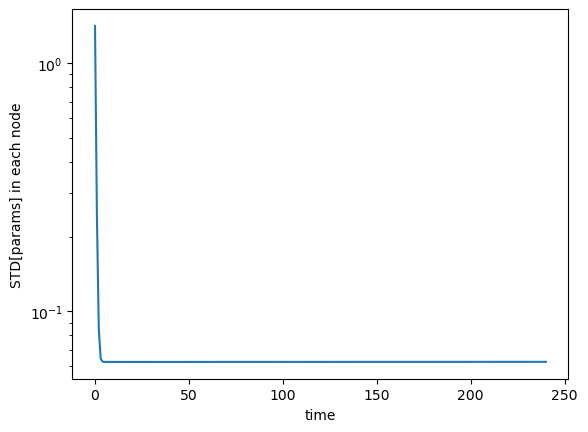

In [133]:
x = [r["round"] for r in rounds]
y = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
plt.plot(x, np.array(y))
# plt.ylim(0, None)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

In [134]:
np.min(y), y[-1]

(0.062479857355356216, 0.06252877414226532)

Text(0, 0.5, 'STD[param] across node')

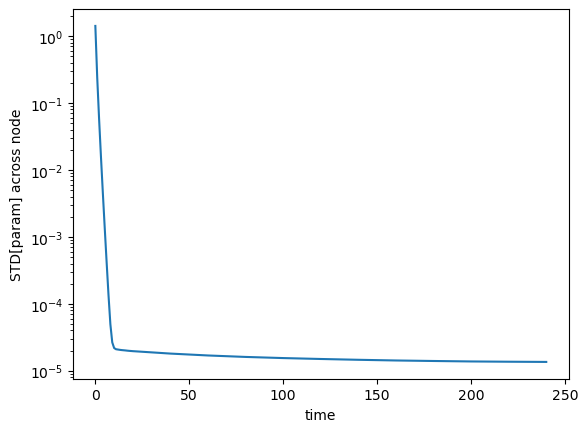

In [135]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x, y)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

(-1.05, 0.1617359546915395)

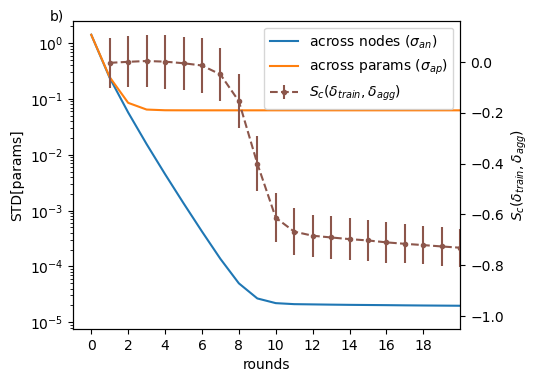

In [136]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

fig, ax = plt.subplots(figsize=(5, 4))
nodes = list(rounds[0]["test_losses"])
x = [r["round"] for r in rounds]
y_ap = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
y_an = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
y_train_agg_sim = []
for n in nodes:
    y_train_agg_sim.append([
        cosine_sim(
            r["training_changes"][n]["fc2.weight"],
            r["aggregation_changes"][n]["fc2.weight"])
        for r in rounds[1:]])


l1, = ax.plot(x, np.array(y_an), label="across nodes ($\\sigma_{an}$)")
l2, = ax.plot(x, np.array(y_ap), label="across params ($\\sigma_{ap}$)")
ax.set_xlim(-1, 20)
# ax.set_ylim(2e-5, 7e-1)
ax.set_yscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("STD[params]")
ax.text(-0.06, 1.0, "b)", transform=ax.transAxes)
ax.set_xticks(range(0, 20, 2))
ax2 = ax.twinx()
l3 = ax2.errorbar(x[1:],
                  np.mean(y_train_agg_sim, axis=0),
                  yerr=np.std(y_train_agg_sim, axis=0),
                  marker=".", ls='--', color="tab:brown",
                  label="$S_c(\\delta_{train}, \\delta_{agg})$")
lns = [l1, l2, l3]
ax.legend(lns, [l.get_label() for l in lns])
ax2.set_ylabel("$S_c(\\delta_{train}, \\delta_{agg})$")
ax2.set_ylim(-1.05, None)
# fig.savefig("figures/params_stds.pdf", dpi=300)

Text(0, 0.5, '$|\\delta(param)|$')

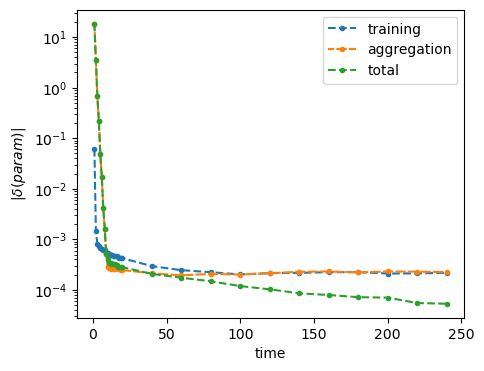

In [137]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

fig, ax = plt.subplots(figsize=(5, 4))

param = "fc3.weight"
x = [r["round"] for r in rounds[1:]]
y1 = [np.linalg.norm(r["training_changes"]['0'][param]) for r in rounds[1:]]
y2 = [np.linalg.norm(r["aggregation_changes"]['0'][param]) for r in rounds[1:]]
y3 = [np.linalg.norm(r["aggregation_changes"]['0'][param] + r["training_changes"]['0'][param])
      for r in rounds[1:]]
y_train_agg_sim = [cosine_sim(r["training_changes"]['0'][param], r["aggregation_changes"]['0'][param])
                        for r in rounds[1:]]

ax.plot(x, y1, label="training", marker=".", ls='--')
ax.plot(x, y2, label="aggregation", marker=".", ls=(2, (5, 1)))
ax.plot(x, y3, label="total", marker=".", ls='--')

# ax2 = ax.twinx()
# l3 = ax2.errorbar(
#     x,
#     y_train_agg_sim,
#     # yerr=np.std(y_train_agg_sim, axis=0),
#     marker=".", ls='--', color="tab:brown",
#     label="$S_c(\\delta_{train}, \\delta_{agg})$")


ax.set_yscale("log")
ax.legend()
ax.set_xlabel("time")
ax.set_ylabel("$|\delta(param)|$")
# fig.savefig("figures/delta_params.png", dpi=300)

0.5006844313392416

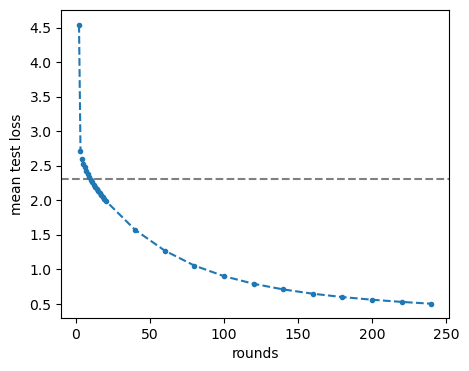

In [138]:
fig, ax = plt.subplots(figsize=(5, 4))

x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_losses"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

ax.errorbar(x[2:], y[2:], yerr=yerr[2:], marker=".", ls='--')
ax.axhline(np.log(10), color="grey", ls='--')
ax.set_xlabel("rounds")
ax.set_ylabel("mean test loss")
y[-1]

Text(0, 0.5, 'mean test accuracy')

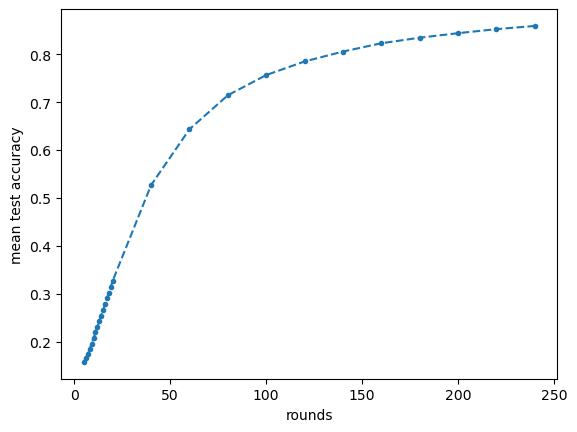

In [139]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_accuracies"])
y = np.array([np.mean([r["test_accuracies"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_accuracies"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[5:], y[5:], yerr=yerr[5:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test accuracy")

In [140]:
y[-1]

0.85940625

Text(0, 0.5, '-diff[mean test loss]')

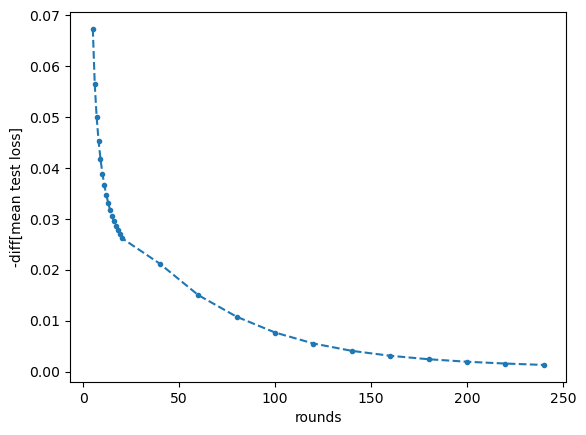

In [141]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
plt.plot(x[5:], -np.diff(y)[4:]/np.diff(x)[4:], marker=".", ls='--')
#plt.yscale("log")
#plt.ylim(1e-30, 1e-5)
plt.xlabel("rounds")
plt.ylabel("-diff[mean test loss]")

In [142]:
y[-2] - y[-1]

0.026151703402120585

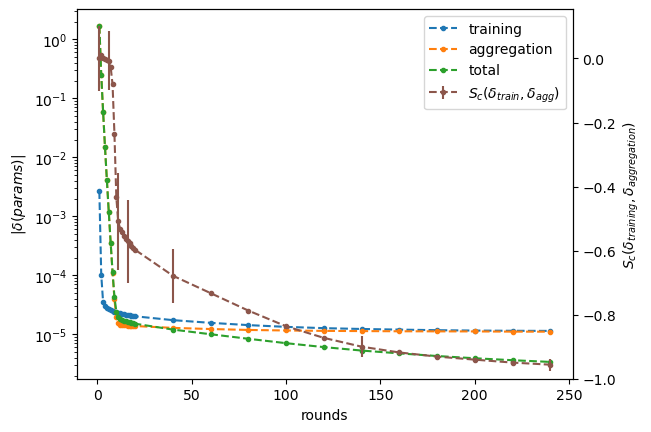

In [143]:
def cosine_sim(a, b):
    return np.dot(a, b)/(np.linalg.norm(a)*np.linalg.norm(b))

fig, ax = plt.subplots()

min_t = 1
x = [r["round"] for r in rounds[min_t:]]
nodes = list(rounds[0]["test_losses"])

param = "fc3.weight"
y_train = []
y_agg = []
y_total = []
y_sum_abs = []
y_train_agg_sim = []
for n in nodes:
    y_train.append([r["training_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param].abs().mean() for r in rounds[min_t:]])
    y_sum_abs.append([(r["aggregation_changes"][n][param].abs() + r["training_changes"][n][param].abs()).mean()
          for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param]).abs().mean()
          for r in rounds[min_t:]])
    y_train_agg_sim.append([cosine_sim(r["training_changes"][n][param], r["aggregation_changes"][n][param])
                            for r in rounds[min_t:]])
l1, = ax.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
l2, = ax.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
l3, = ax.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
# ax.plot(x, np.mean(y_sum_abs, axis=0), label="sum(abs)", marker=".", ls='--')
# ax.plot(x, np.mean(y_total, axis=0)/np.mean(y_sum_abs, axis=0), label="total/sum(abs)", marker=".", ls='--')
ax.set_yscale("log")
ax.set_ylabel("$|\\delta(params)|$")
ax.set_xlabel("rounds")

ax2 = ax.twinx()
l4 = ax2.errorbar(
        x, np.mean(y_train_agg_sim, axis=0), yerr=np.std(y_train_agg_sim, axis=0),
        marker=".",
        ls='--',
        errorevery=5,
        color="tab:brown",
        label="$S_c(\\delta_{train}, \\delta_{agg})$")
ax2.set_ylabel("$S_c(\\delta_{training}, \\delta_{aggregation})$")
ax2.set_ylim(-1, None)
lns = [l1, l2, l3, l4]
ax.legend(lns, [l.get_label() for l in lns])
# fig.savefig("figures/delta_params.png", dpi=300)

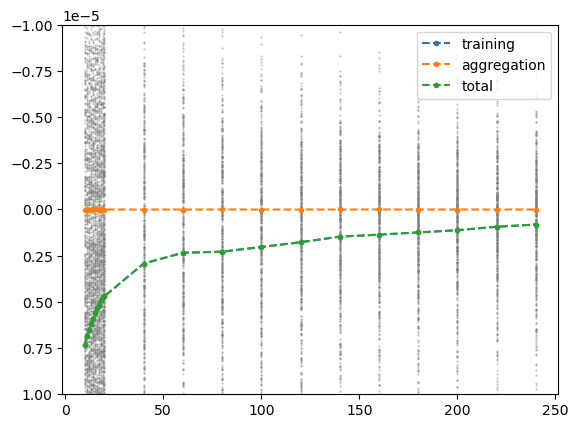

In [144]:
min_t = 10
x = [r["round"] for r in rounds[min_t:]]
idx = 10
y_train = []
y_agg = []
y_total = []
for n in nodes:
    y_train.append([r["training_changes"][n][param][idx] for r in rounds[min_t:]])
    y_agg.append([r["aggregation_changes"][n][param][idx] for r in rounds[min_t:]])
    y_total.append([(r["aggregation_changes"][n][param] + r["training_changes"][n][param])[idx]
          for r in rounds[min_t:]])
plt.plot(x, np.mean(y_train, axis=0), label="training", marker=".", ls='--')
plt.plot(np.repeat(np.array(x)[np.newaxis, :], len(nodes), axis=0), y_train, marker=".", ms=1, ls='', color="grey", alpha=0.5)

plt.plot(x, np.mean(y_agg, axis=0), label="aggregation", marker=".", ls='--')
plt.plot(x, np.mean(y_total, axis=0), label="total", marker=".", ls='--')
plt.ylim(1e-5, -1e-5)
plt.legend()

Text(0, 0.5, 'STD[params] in each node')

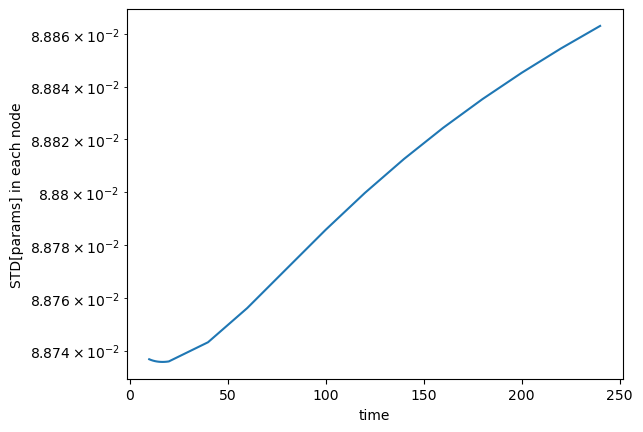

In [145]:
x = [r["round"] for r in rounds]
y = [np.mean([r["stds_across_params"][n][param] for n in nodes]) for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

Text(0, 0.5, 'STD[param] across node')

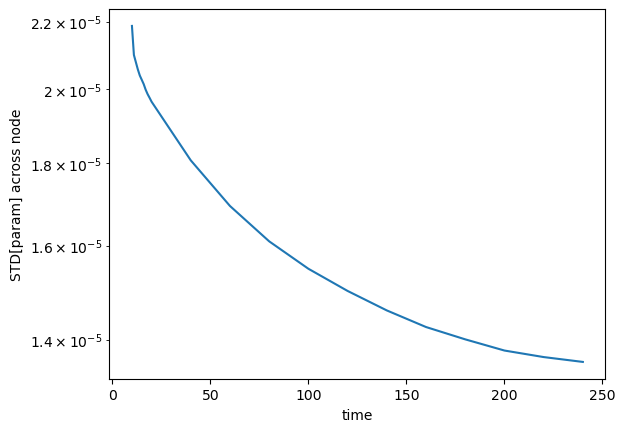

In [146]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x[min_t:], y[min_t:])
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

## Update/Data ratio

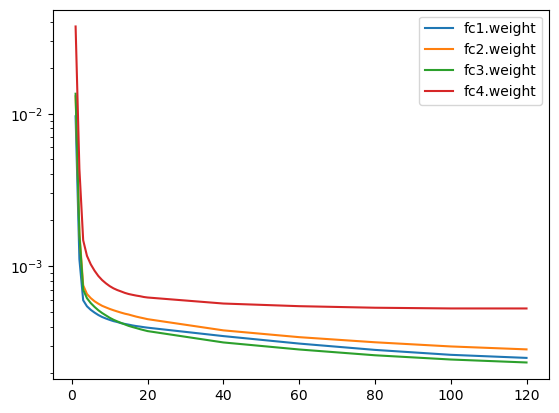

In [102]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    du = []
    xs = []
    for r in rounds[1:]:
        xs.append(r["round"])
        du.append([
            (r["training_changes"][n][param].std()/r["params"][n][param].std()).tolist()
            for n in nodes])
    ax.plot(xs, np.mean(du, axis=1), label=param)
ax.legend()
ax.set_yscale("log")

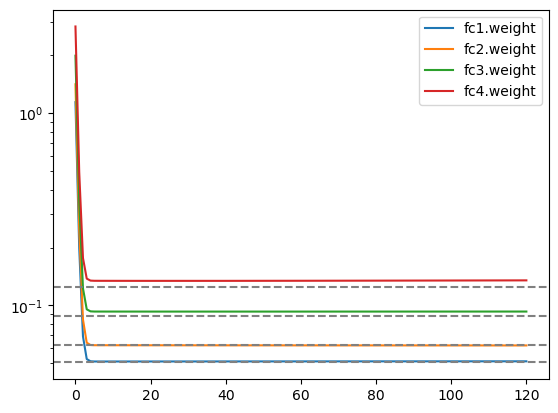

In [103]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
fan_ins = {"fc1.weight": 784, "fc2.weight": 512, "fc3.weight": 256, "fc4.weight": 128}
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    stds = []
    xs = []
    for r in rounds:
        weights = []
        xs.append(r["round"])
        for n in nodes:
            weights.extend(r["params"][n][param].tolist())
        stds.append(np.std(weights))
    ax.plot(xs, stds, label=param)
    ax.axhline((2/fan_ins[param])**0.5, ls='--', color="grey")
    
ax.set_yscale("log")
ax.legend()

# Scaling with size

In [2]:
def process_file(logfile, size):
    with gzip.open(logfile, 'rt') as f:
        test_loss = []
        for line in f:
            j = json.loads(line, cls=decoder.TorchTensorDecoder)
            test_loss.append(np.mean(list(j["test_losses"].values())))
    return size, test_loss

test_losses = {}
with ProcessPoolExecutor(max_workers=4) as ex:
    futures = []
    for size in [512, 256, 128, 64]:
        files = pathlib.Path("logs/regular/").glob(f"nodes-{size}-degree-32-seed-*-heterogeneous-init-1-epochs-simple-balanced_iid-100-items.jsonl.gz")
        for logfile in tqdm(list(files)):
            futures.append(ex.submit(process_file, logfile, size))
            
        test_losses[size] = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        size, test_loss = future.result()
        test_losses[size].append(test_loss)

0it [00:00, ?it/s]
100%|██████████| 40/40 [15:29<00:00, 23.24s/it]  


256 4080 0.16771459276721723
128 4080 0.18705594407546014
64 4080 0.2272329255639248


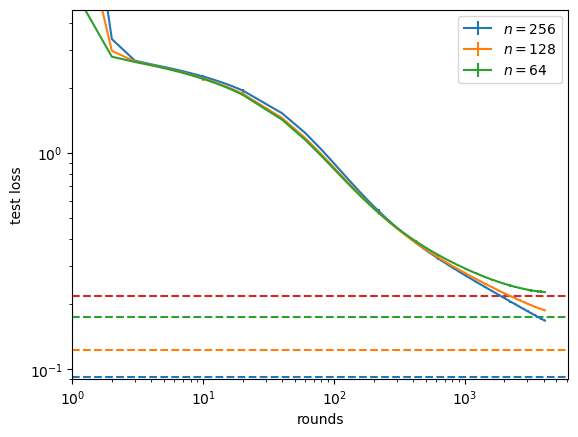

In [3]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    if not test_loss:
        continue
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"$n={size}$")
    print(size, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(1, None)
ax.set_ylim(9e-2, 2*np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_size.pdf")

512 49 0.34419458828746574
256 104 0.22245968326043802
128 176 0.19152661225571066
64 224 0.22773007224389147


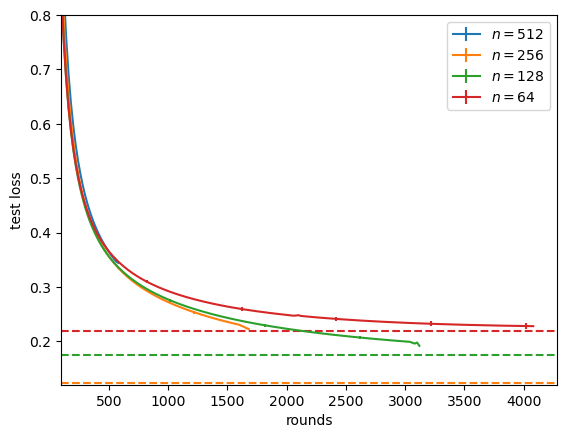

In [209]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=(int(np.log2(size))*10, 40),
            label=f"$n={size}$")
    print(size, max_len, np.min(np.nanmean(loss, axis=0)))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(100, None)
ax.set_ylim(1.2e-1, 8e-1)
ax.legend()
# fig.savefig("figures/test_loss_scaling_size.pdf")

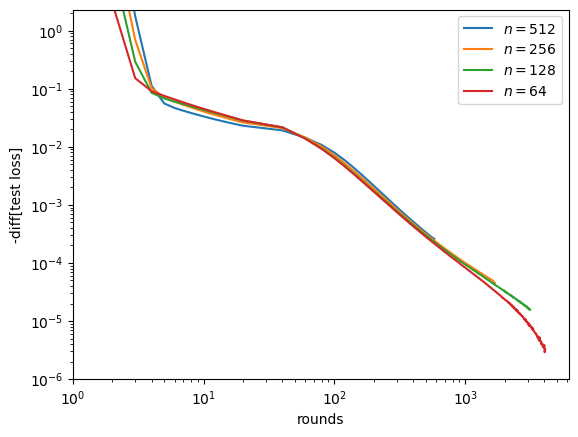

In [211]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.plot(x[1:],
            np.nanmean(-np.diff(loss)/np.diff(x), axis=0),
            # yerr=1.96*(np.nanstd(loss, axis=0)/(np.sum(np.array(loss) != np.nan, axis=0) - 1)**0.5),
            label=f"$n={size}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("-diff[test loss]")
ax.set_xlim(1, None)
ax.set_ylim(1e-6, np.log(10))
ax.legend()

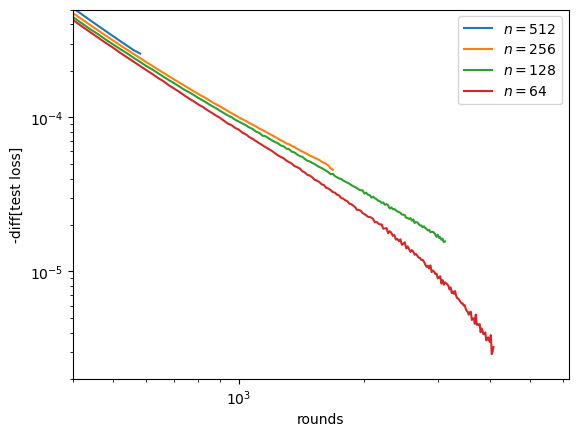

In [220]:
fig, ax = plt.subplots()

for size, test_loss in test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.plot(x[1:],
            np.nanmean(-np.diff(loss)/np.diff(x), axis=0),
            label=f"$n={size}$")
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("-diff[test loss]")
ax.set_xlim(400, None)
ax.set_ylim(2e-6, 5e-4)
ax.legend()

# Isolated node scaling

In [171]:
isolated_test_losses = {}

def process_isolated_file(logfile, size):
    with gzip.open(logfile, 'rt') as f:
        test_loss = []
        for line in f:
            j = json.loads(line, cls=decoder.TorchTensorDecoder)
            test_loss.append(j["test_losses"])
    return size, test_loss

            
isolated_test_losses = {}
with ProcessPoolExecutor(max_workers=4) as ex:
    futures = []
    for items in [51200, 25600, 12800, 6400]:
        files = pathlib.Path("logs/networks/isolated/").glob(f"seed-*-init-4-epochs-simple-balanced_iid-{items}-items.jsonl")
        for logfile in tqdm(list(files)):
            futures.append(ex.submit(process_isolated_file, logfile, items))
            
        isolated_test_losses[items] = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        items, test_loss = future.result()
        isolated_test_losses[items].append(test_loss)
# rounds = rounds[:128]

0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]
0it [00:00, ?it/s]


51200 0.09158002484133465
25600 0.12332988646640441
12800 0.17453373824404553
6400 0.21811503203079727


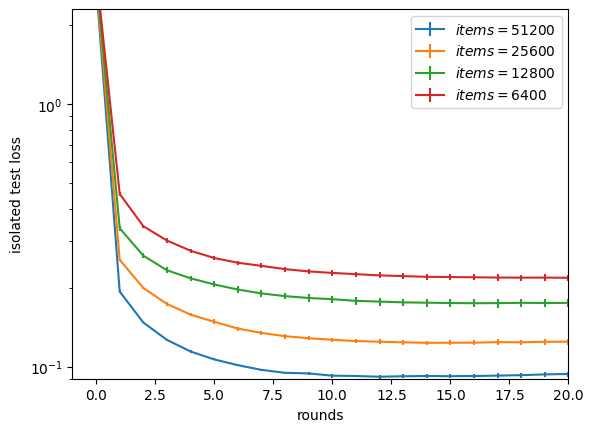

In [60]:
fig, ax = plt.subplots()

for items, test_loss in isolated_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    ax.errorbar(
            x=np.arange(max_len),
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            label=f"$items={items}$")
    print(items, np.min(np.mean(loss, axis=0)))
ax.set_yscale("log")
#ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("isolated test loss")
ax.set_xlim(-1, 20)
ax.set_ylim(9e-2, np.log(10))
ax.legend()
fig.savefig("figures/isolated_test_loss_scaling_items.pdf")

[51200, 25600, 12800, 6400]


Text(0, 0.5, 'isolated test loss')

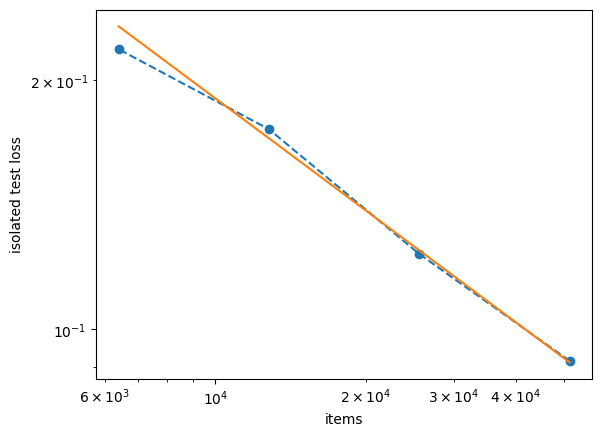

In [92]:
fig, ax = plt.subplots()

item_counts = []
min_losses = []
for items, test_loss in isolated_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    item_counts.append(items)
    min_losses.append(np.min(np.mean(loss, axis=0)))
print(item_counts)
ax.plot(item_counts, min_losses, ls='--', marker='o')
ax.plot(item_counts, 12*np.array(item_counts)**-0.45)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("items")
ax.set_ylabel("isolated test loss")
# ax.set_xlim(-1, 20)
# ax.set_ylim(9e-2, np.log(10))
# ax.legend()
# fig.savefig("figures/isolated_test_loss_scaling_items.pdf")

# Scaling with degree

In [221]:
degree_test_losses = {}
with ProcessPoolExecutor(max_workers=4) as ex:
    futures = []
    for degree in [32, 16, 8, 4, 3, 2]:
        files = pathlib.Path("logs/regular/").glob(f"nodes-64-degree-{degree}-seed-*-heterogeneous-init-1-epochs-simple-balanced_iid-100-items.jsonl.gz")
        for logfile in tqdm(list(files)):
            futures.append(ex.submit(process_file, logfile, degree))
            
        degree_test_losses[degree] = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        degree, test_loss = future.result()
        degree_test_losses[degree].append(test_loss)

100%|██████████| 96/96 [14:06<00:00,  8.81s/it]


32 4080 0.22773007224389147
16 4080 0.22054661902350198
8 4080 0.22732470301475405
4 4080 0.2261661776874484
3 4080 0.2315492066331208
2 4080 0.25101409334464914


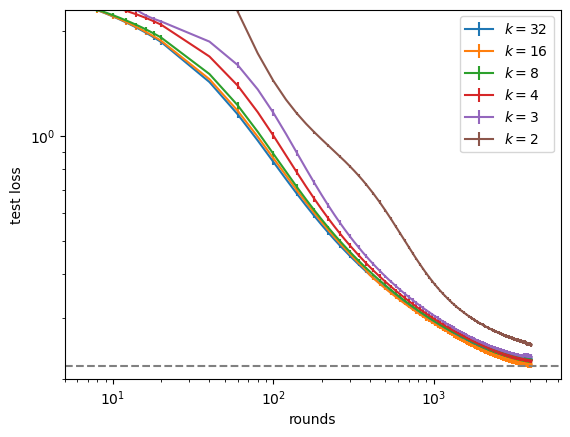

In [222]:
fig, ax = plt.subplots()

for degree, test_loss in degree_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=2,
            label=f"$k={degree}$")
    print(degree, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.21811503203079727, ls='--', color="grey")
ax.set_xlim(5, None)
ax.set_ylim(2e-1, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_degree.png", dpi=300)

32 0.22773007224389147
16 0.22054661902350198
8 0.22732470301475405
4 0.2261661776874484
3 0.2315492066331208
2 0.25101409334464914


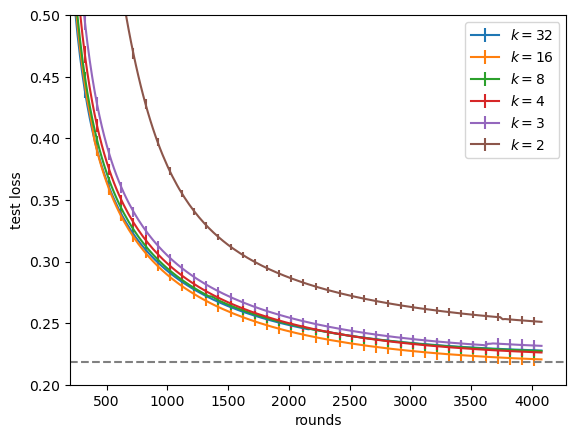

In [223]:
fig, ax = plt.subplots()

for degree, test_loss in degree_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=5,
            label=f"$k={degree}$")
    print(degree, np.min(np.nanmean(loss, axis=0)))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.21811503203079727, ls='--', color="grey")
ax.set_xlim(200, None)
ax.set_ylim(2.0e-1, 5e-1)
ax.legend()
# fig.savefig("figures/test_loss_scaling_degree.pdf")

32 4080 0.22773007224389147
16 4080 0.22054661902350198
8 4080 0.22732470301475405
4 4080 0.2261661776874484
3 4080 0.2315492066331208
2 4080 0.25101409334464914


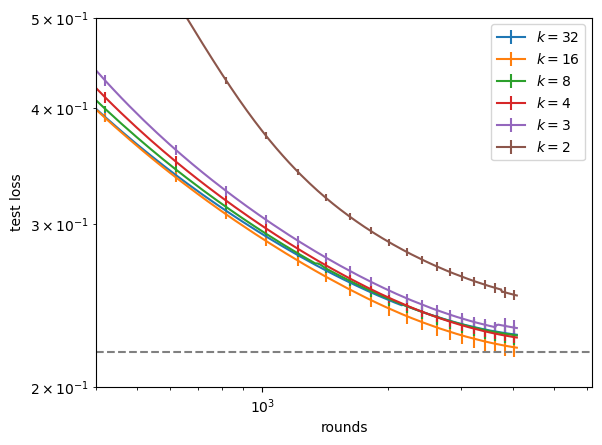

In [224]:
fig, ax = plt.subplots()

for degree, test_loss in degree_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"$k={degree}$")
    print(degree, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.21811503203079727, ls='--', color="grey")
ax.set_xlim(400, None)
ax.set_ylim(2.0e-1, 5e-1)
ax.legend()

# Scaling with items

In [167]:
items_test_losses = {}
with ProcessPoolExecutor(max_workers=4) as ex:
    futures = []
    for items in [800, 400, 200, 100]:
        files = pathlib.Path("logs/regular/").glob(f"nodes-64-degree-32-seed-*-heterogeneous-init-1-epochs-simple-balanced_iid-{items}-items.jsonl.gz")
        for logfile in tqdm(list(files)):
            futures.append(ex.submit(process_file, logfile, items))
            
        items_test_losses[items] = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        items, test_loss = future.result()
        items_test_losses[items].append(test_loss)

100%|██████████| 56/56 [05:59<00:00,  6.43s/it]


800 2620 0.09369538231347149
400 4080 0.1266685705301773
200 4080 0.17156685868822494
100 4080 0.22773007224389147


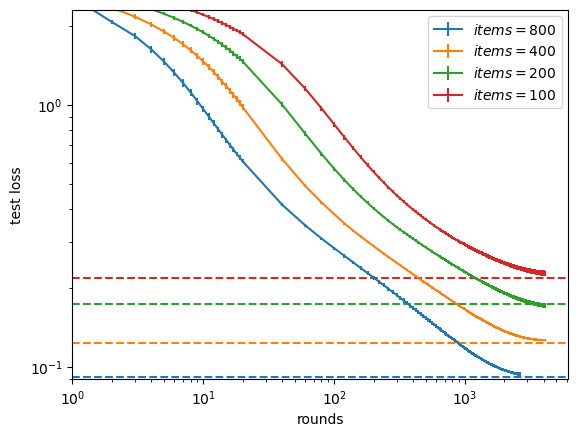

In [175]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=1,
            label=f"$items={items}$")
    print(items, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(1, None)
ax.set_ylim(9.0e-2, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_items.png", dpi=300)

800 2620 0.09369538231347149
400 4080 0.1266685705301773
200 4080 0.17156685868822494
100 4080 0.22773007224389147


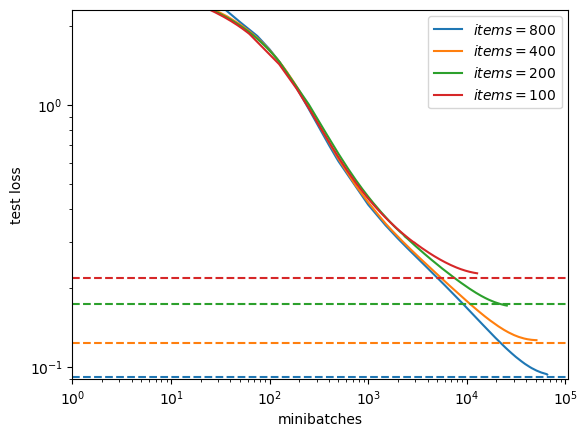

In [176]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.plot(np.array(x)*items/32,
            np.nanmean(loss, axis=0),
            # yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            # errorevery=10,
            label=f"$items={items}$")
    print(items, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("minibatches")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(1, None)
ax.set_ylim(9.0e-2, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_items_minibatches.pdf", dpi=300)

800 0.09369538231347149
400 0.1266685705301773
200 0.17156685868822494
100 0.22773007224389147


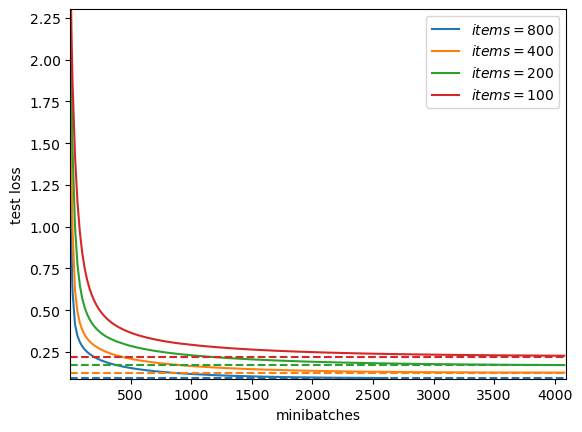

In [177]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.plot(x,
            np.nanmean(loss, axis=0),
            # yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            # errorevery=10,
            label=f"$items={items}$")
    print(items, np.min(np.nanmean(loss, axis=0)))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("minibatches")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(1, 4096)
ax.set_ylim(9.0e-2, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_items_minibatches.pdf", dpi=300)

800 0.09369538231347149
400 0.1266685705301773
200 0.17156685868822494
100 0.22773007224389147


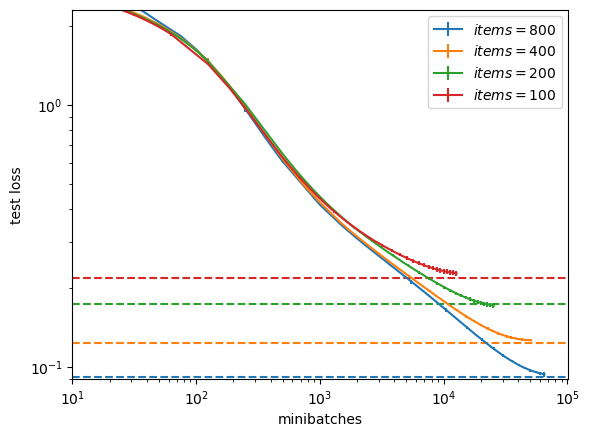

In [178]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=np.array(x)*items/32,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"$items={items}$")
    print(items, np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("minibatches")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(10, 25*4096)
ax.set_ylim(9.0e-2, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_items_minibatches.pdf", dpi=300)

800 0.09369538231347149
400 0.1266685705301773
200 0.17156685868822494
100 0.22773007224389147


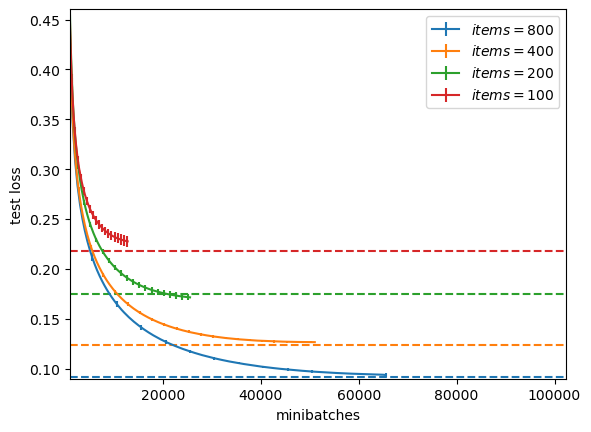

In [179]:
fig, ax = plt.subplots()

for items, test_loss in items_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=np.array(x)*items/32,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"$items={items}$")
    print(items, np.min(np.nanmean(loss, axis=0)))
# ax.set_yscale("log")
# ax.set_xscale("log")
ax.set_xlabel("minibatches")
ax.set_ylabel("test loss")
ax.axhline(0.09158002484133469, ls='--', color="tab:blue")
ax.axhline(0.12332988646640441, ls='--', color="tab:orange")
ax.axhline(0.17453373824404553, ls='--', color="tab:green")
ax.axhline(0.21811503203079727, ls='--', color="tab:red")
ax.set_xlim(1024, 25*4096)
ax.set_ylim(9.0e-2, 0.2*np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_items_minibatches.pdf", dpi=300)

# Scaling with local epochs

In [180]:
epochs_test_losses = {}
with ProcessPoolExecutor(max_workers=4) as ex:
    futures = []
    for epochs in [32, 16, 8, 4, 2, 1]:
        files = pathlib.Path("logs/regular/").glob(f"nodes-64-degree-32-seed-*-heterogeneous-init-{epochs}-epochs-simple-balanced_iid-100-items.jsonl.gz")
        for logfile in tqdm(list(files)):
            futures.append(ex.submit(process_file, logfile, epochs))
            
        epochs_test_losses[epochs] = []
    for future in tqdm(as_completed(futures), total=len(futures)):
        epochs, test_loss = future.result()
        epochs_test_losses[epochs].append(test_loss)

100%|██████████| 64/64 [07:23<00:00,  6.93s/it]


32 1040 0.27848449205967235
16 1680 0.25539236474725896
8 3080 0.23624309063107501
4 3960 0.23070074226658321
2 4080 0.22246323991574937
1 4080 0.22773007224389147


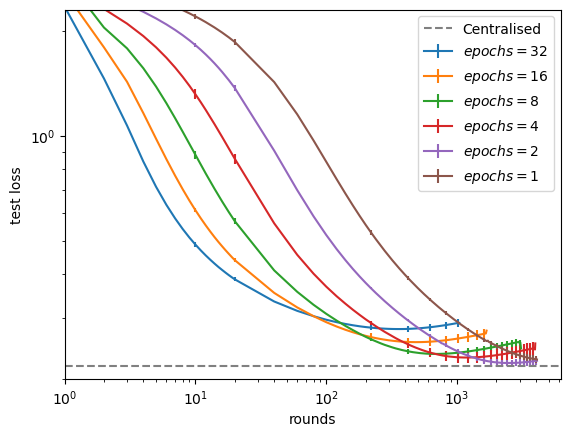

In [182]:
fig, ax = plt.subplots()

for epochs, test_loss in epochs_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=x,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"$epochs={epochs}$")
    print(epochs, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("test loss")
ax.axhline(0.21811503203079727, ls='--', color="grey", label="Centralised")
ax.set_xlim(1, None)
ax.set_ylim(2e-1, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_epochs.png", dpi=300)

32 1040 0.27848449205967235
16 1680 0.25539236474725896
8 3080 0.23624309063107501
4 3960 0.23070074226658321
2 4080 0.22246323991574937
1 4080 0.22773007224389147


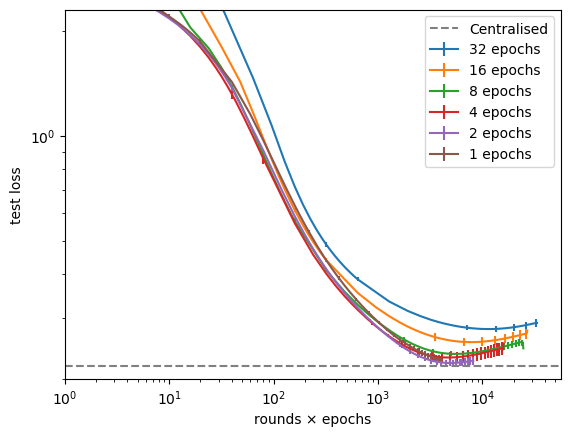

In [189]:
fig, ax = plt.subplots()


for epochs, test_loss in epochs_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=np.array(x)*epochs,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=10,
            label=f"{epochs} epochs")
    print(epochs, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds × epochs")
ax.set_ylabel("test loss")
ax.axhline(0.21811503203079727, ls='--', color="grey", label="Centralised")
ax.set_xlim(1, None)
ax.set_ylim(2e-1, np.log(10))
ax.legend()
# fig.savefig("figures/test_loss_scaling_epochs_scaled.png", dpi=300)

32 1040 0.27848449205967235
16 1680 0.25539236474725896
8 3080 0.23624309063107501
4 3960 0.23070074226658321
2 4080 0.22246323991574937
1 4080 0.22773007224389147


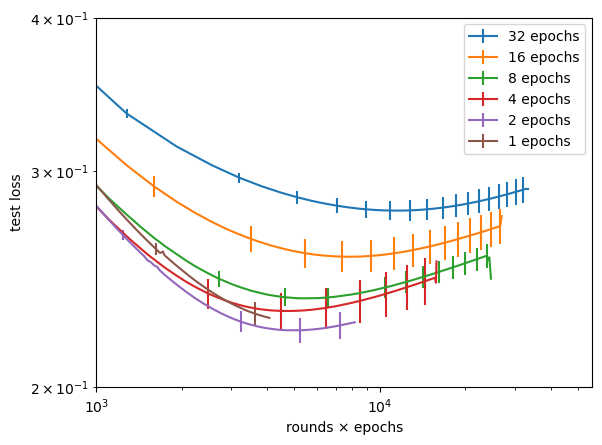

In [198]:
fig, ax = plt.subplots()


for epochs, test_loss in epochs_test_losses.items():
    max_len = max(map(len, test_loss))
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    x = list(range(min(20, max_len))) + list(range(20, (max_len-19)*20, 20))
    ax.errorbar(
            x=np.array(x)*epochs,
            y=np.nanmean(loss, axis=0),
            yerr=1.96*(np.nanstd(loss, axis=0)/np.sum(~np.isnan(loss), axis=0)**0.5),
            errorevery=100//epochs,
            label=f"{epochs} epochs")
    print(epochs, x[-1], np.min(np.nanmean(loss, axis=0)))
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("rounds × epochs")
ax.set_ylabel("test loss")
# ax.axhline(0.21811503203079727, ls='--', color="grey", label="Centralised")
ax.set_xlim(1e3, None)
ax.set_ylim(2e-1, 4e-1)
ax.legend()
# fig.savefig("figures/test_loss_scaling_epochs_scaled.png", dpi=300)

[32, 16, 8, 4, 2, 1]
[0.27848449205967235, 0.25539236474725896, 0.23624309063107501, 0.23070074226658321, 0.22246323991574937, 0.22773007224389147]


/tmp/ipykernel_7269/1599788745.py:8: RuntimeWarning: Mean of empty slice
  min_loss = np.nanmean(loss, axis=0)


Text(0, 0.5, 'minimum test loss')

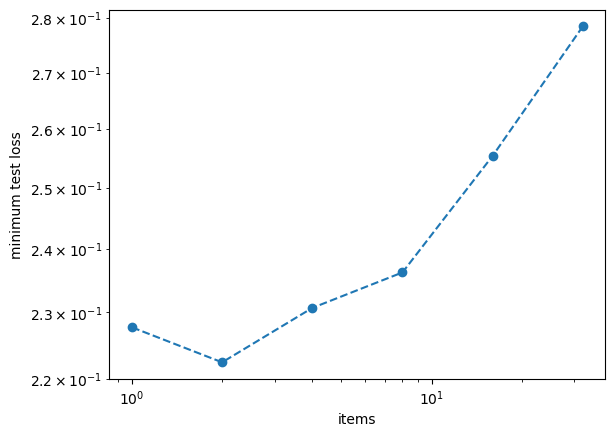

In [206]:
fig, ax = plt.subplots()

item_counts = []
min_losses = []
for items, test_loss in epochs_test_losses.items():
    loss = [l + [np.nan]*(max_len - len(l)) for l in test_loss]
    # print(np.nanmean(loss, axis=0))
    min_loss = np.nanmean(loss, axis=0)
    item_counts.append(items)
    min_losses.append(np.nanmin(min_loss))
print(item_counts)
print(min_losses)
ax.plot(item_counts, min_losses, ls='--', marker='o')
# ax.plot(item_counts, 12*np.array(item_counts)**-0.45)
ax.set_yscale("log")
ax.set_xscale("log")
ax.set_xlabel("items")
ax.set_ylabel("minimum test loss")
# ax.set_xlim(-1, 20)
# ax.set_ylim(9e-2, np.log(10))
# ax.legend()
# fig.savefig("figures/isolated_test_loss_scaling_items.pdf")

# Homogeneous init

In [5]:
logfile = "logs/networks/regular/nodes-64-degree-32-seed-0-homogeneous-init-1-simple-balanced_iid-100-itens.jsonl"

rounds = []
with open(logfile) as f:
    for line in tqdm(f):
        rounds.append(json.loads(line, cls=decoder.TorchTensorDecoder))
# rounds = rounds[:128]
print(len(rounds))

1671it [01:25, 19.60it/s]

1671


Text(0, 0.5, 'STD[params] in each node')

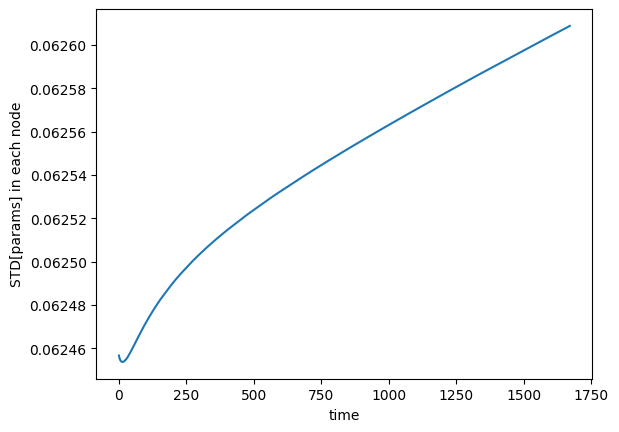

In [6]:
x = [r["round"] for r in rounds]
y = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
plt.plot(x, np.array(y))
# plt.ylim(0, None)
# plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[params] in each node")

Text(0, 0.5, 'STD[param] across node')

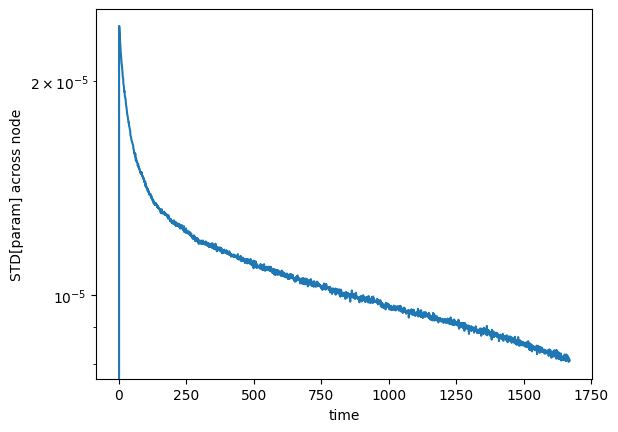

In [7]:
x = [r["round"] for r in rounds]
y = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]
plt.plot(x, y)
plt.yscale("log")
plt.xlabel("time")
plt.ylabel("STD[param] across node")

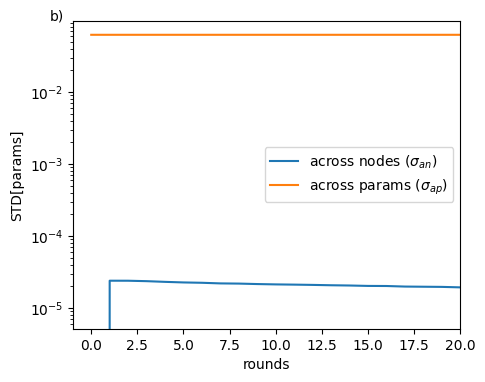

In [8]:
fig, ax = plt.subplots(figsize=(5, 4))
x = [r["round"] for r in rounds]
y_ap = [r["stds_across_params"]['0']["fc2.weight"] for r in rounds]
y_an = [r["stds_across_nodes"]["fc2.weight"].mean() for r in rounds]

ax.plot(x, np.array(y_an), label="across nodes ($\\sigma_{an}$)")
ax.plot(x, np.array(y_ap), label="across params ($\\sigma_{ap}$)")
ax.set_xlim(-1, 20)
# ax.set_ylim(2e-5, 7e-1)
ax.legend()
ax.set_yscale("log")
ax.set_xlabel("rounds")
ax.set_ylabel("STD[params]")
ax.text(-0.06, 1.0, "b)", transform=ax.transAxes)
fig.savefig("figures/homogeneous_params_stds.pdf")

Text(0, 0.5, '$|\\delta(param)|$')

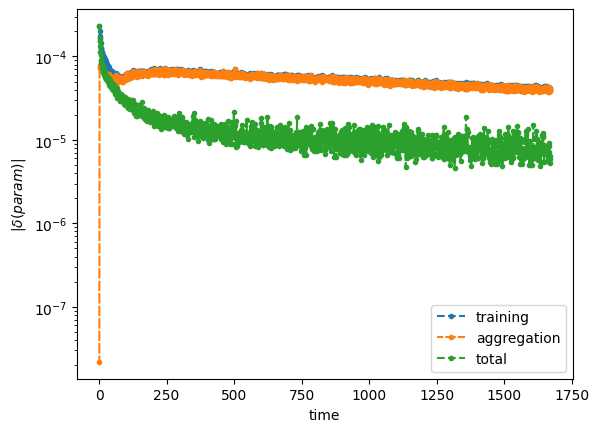

In [9]:
x = [r["round"] for r in rounds[1:]]
y1 = [r["training_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y2 = [r["aggregation_changes"]['0']["fc4.weight"].abs().mean() for r in rounds[1:]]
y3 = [(r["aggregation_changes"]['0']["fc4.weight"] + r["training_changes"]['0']["fc4.weight"]).abs().mean()
      for r in rounds[1:]]
plt.plot(x, y1, label="training", marker=".", ls='--')
plt.plot(x, y2, label="aggregation", marker=".", ls=(2, (5, 1)))
plt.plot(x, y3, label="total", marker=".", ls='--')
plt.yscale("log")
plt.legend()
plt.xlabel("time")
plt.ylabel("$|\delta(param)|$")

0.2627919556702487

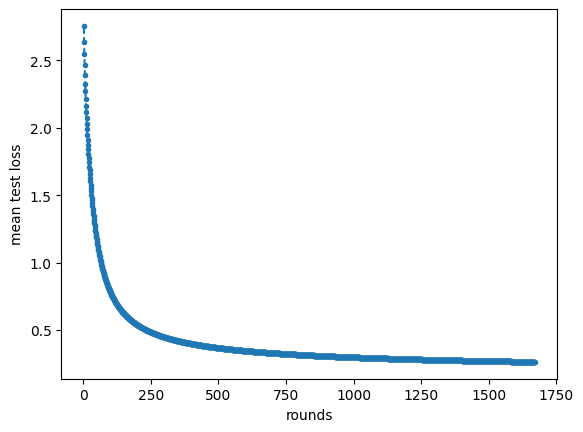

In [10]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_losses"])
y = np.array([np.mean([r["test_losses"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_losses"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[2:], y[2:], yerr=yerr[2:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test loss")
y[-1]

Text(0, 0.5, 'mean test accuracy')

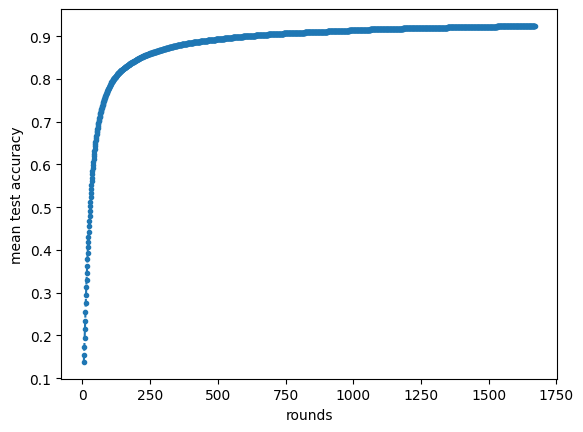

In [11]:
x = [r["round"] for r in rounds]
nodes = list(rounds[0]["test_accuracies"])
y = np.array([np.mean([r["test_accuracies"][n] for n in nodes]) for r in rounds])
yerr = np.array([np.std([r["test_accuracies"][n] for n in nodes])/len(nodes)**0.5 for r in rounds])

plt.errorbar(x[5:], y[5:], yerr=yerr[5:], marker=".", ls='--')
plt.xlabel("rounds")
plt.ylabel("mean test accuracy")

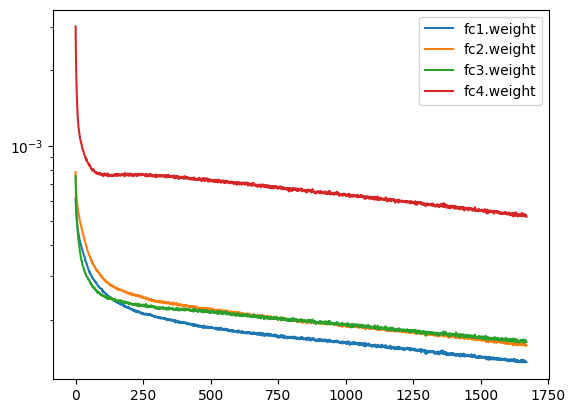

In [12]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    du = []
    for r in rounds[1:]:
        du.append([
            (r["training_changes"][n][param].std()/r["params"][n][param].std()).tolist()
            for n in nodes])
    ax.plot(np.mean(du, axis=1), label=param)
ax.legend()
ax.set_yscale("log")

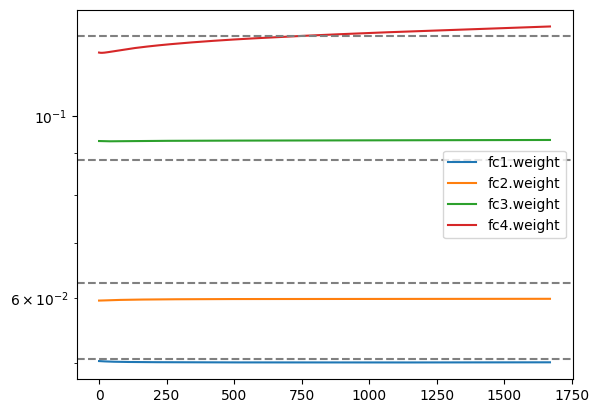

In [13]:
fig, ax = plt.subplots()
nodes = list(rounds[0]["params"])
fan_ins = {"fc1.weight": 784, "fc2.weight": 512, "fc3.weight": 256, "fc4.weight": 128}
for param in list(rounds[0]["params"][nodes[0]]):
    if param.endswith("bias"):
        continue
    stds = []
    for r in rounds:
        weights = []
        for n in nodes:
            weights.extend(r["params"][n][param].tolist())
        stds.append(np.std(weights))
    ax.plot(stds, label=param)
    ax.axhline((2/fan_ins[param])**0.5, ls='--', color="grey")
    
ax.set_yscale("log")
ax.legend()